# Class Imbalance

In [1]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import tensorflow as tf

2025-01-21 10:26:22.289016: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_file_path = "../data/clean_fer_2013/"

## Is there still Class Imbalance in the clean dataset?

In the preprocessing step, I removed duplicates and poor quality images. This reduced the training dataset from 28,709 images to 26,767 images.

We can see that removing images has retained the general distribution i.e. that there are far more "happy" images than "disgust" images. Unfortunately our preprocessing has accentuated the difference, but only very slightly.


In [3]:
def get_meta_train(training_data_path):
    """
    Retrieve basic information about training images

    Args:
        training_data_path: (str) path to the training folder containing all training images
        
    Returns:
        list of dictionaries, each containing metadata about the image
    
    """
    file_meta = []
    

    for name in os.listdir(training_data_path): 
        filepath = os.path.join(training_data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)
        
            stats = os.stat(image_filepath)
            with Image.open(image_filepath) as img:
                width, height = img.size
    
                mode = img.mode
                
                attrs = {
                    'category': name,
                    'file_name': image_file_name,
                    'file_path': image_filepath,
                }
                file_meta.append(attrs)
    
    return file_meta 

In [4]:
train_data_folder = data_file_path + "train/"

meta_train = get_meta_train(train_data_folder)

df_meta_train = pd.DataFrame(meta_train)
df_meta_train.head(2)

,category,file_name,file_path
0,happy,Training_50449107.jpg,../data/clean_fer_2013/train/happy/Training_50...
1,happy,Training_70433018.jpg,../data/clean_fer_2013/train/happy/Training_70...


In [5]:
len(df_meta_train)

26767

In [6]:
original_data_folder = "../data/fer_2013/train"
meta_original = get_meta_train(original_data_folder)

df_meta_original = pd.DataFrame(meta_original)
len(df_meta_original)

28709

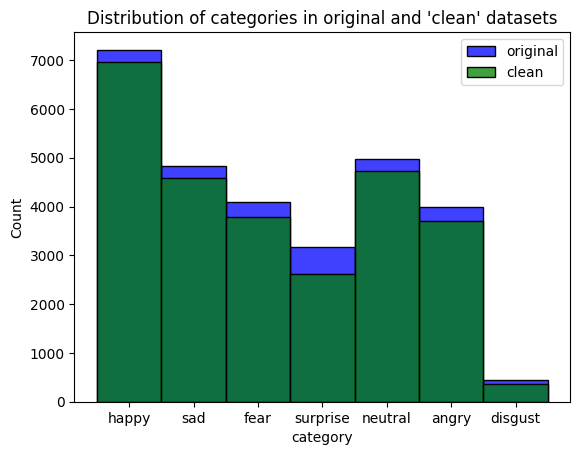

In [7]:
sns.histplot(data=df_meta_original, x="category",color="blue", label="original" )
sns.histplot(data=df_meta_train, x="category", color="green", label="clean")

plt.legend()
plt.title("Distribution of categories in original and 'clean' datasets")
plt.show()

## Solution 1 - Data Augmentation: Creating more images by modifying existing ones

One way to solve class imbalance is to create more images of the minority classes. We can do this by making small adjustments to existing images e.g. we could rotate them slightly, zoom in slightly.

Below I have experimented with a couple of approaches. The `tf.keras.layers` has the most intuitive interface and I was able to apply more transformations.

Looking at the results, you can see that some of the images look quite grainy. Are we augmenting images and merely adding back the blur that we tried to remove earlier?

**Augmentation for Regularization**

Data Augmentation is not primarily used for class balance but for regularization. It can help the model generalise better and reduce overfitting.

**Conclusion**

For our base model, we won't use this kind of data augmentation for class imbalance. I will try introducing it later to see if we get a better model.

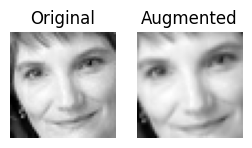

In [8]:
image_path = df_meta_train["file_path"].iloc[0]
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=1) # 1 for grayscale
img = tf.image.resize(img, [48, 48])
img = img / 255.0
img = tf.expand_dims(img, axis=0)

def augment_image(image, min_zoom=0.8, max_zoom=1.0):
    # Apply random zoom
    zoom_factor = tf.random.uniform([], min_zoom, max_zoom, dtype=tf.float32)
    image = tf.image.central_crop(image, central_fraction=zoom_factor)
    image = tf.image.resize(image, [48, 48])  # Resize back to original size

    # Random flip
    image = tf.image.random_flip_left_right(image)
    return image

augmented_image = augment_image(img)

# Plot the original and augmented image for comparison
fig, ax = plt.subplots(1, 2, figsize=(3, 2))
ax[0].imshow(img[0].numpy().squeeze(), cmap="gray")  # Display the original image (remove the batch dimension)
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(augmented_image[0].numpy().squeeze(), cmap="gray")  # Display the augmented image
ax[1].set_title("Augmented")
ax[1].axis('off')

plt.show()

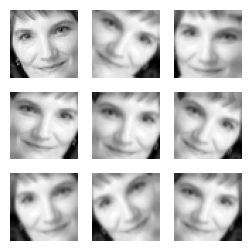

In [9]:
# Augmentation Layers
rotation_layer = tf.keras.layers.RandomRotation(0.05)  # Rotate by up to 5% of 360 degrees i.e. 18 degrees
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.05, width_factor=0.05)  # Zoom by 5%
shift_layer = tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05)  # Shift by 5%
flip_layer = tf.keras.layers.RandomFlip("horizontal")

def augment_image(image):
    image = rotation_layer(image)  # Apply random rotation
    image = zoom_layer(image)  # Apply random zoom
    image = shift_layer(image)  # Apply random translation (shift)
    image = flip_layer(image)
    
    return image

image_path = df_meta_train["file_path"].iloc[0]
img = tf.io.read_file(image_path)
img = tf.image.decode_jpeg(img, channels=1) # 1 for grayscale
img = tf.image.resize(img, [48, 48])
img = img / 255.0
basic_img = tf.expand_dims(img, axis=0)


fig, ax = plt.subplots(3, 3, figsize=(3, 3))  # Adjust grid size
for i in range(3):
    for j in range(3):
        img = basic_img
        if ((i != 0) or (j!=0)):
            img = augment_image(img)
        ax[i, j].imshow(img[0].numpy().squeeze(), cmap="gray")
        ax[i, j].axis('off')  

plt.show()

## Solution 2 - Manipulating Batch Composition

Another approach to manage class imbalance is to balance the batches being sent to model.

We can do this by creating a bespoke generator that ensures that we sample the same number of images for each class regardless of the class distribution.

Below is an example generator that we can pass to the `model.fit(train_generator)` method. Notice that to create an appropriate generator we need to implement the `Sequence` interface.

You can see from the simple test that this will retrieve an equal number of samples per class to counter the class imbalance that exists in the dataset.

One issue with this approach is that it may not be the most efficient.

In [72]:
from tensorflow.keras.utils import Sequence

class ExampleGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size

        self.unique_classes = np.unique(labels)
        self.class_indices = {label: np.where(self.labels == label)[0] for label in self.unique_classes}

    def __len__(self):
        # Calculate the number of batches per epoch
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_images = []
        batch_labels = []
        
        images_per_class = self.batch_size // len(self.unique_classes)
        
        for sampled_category in self.unique_classes:
            # Sample the indices for this class
            class_indices = self.class_indices[sampled_category]
            sampled_indices = np.random.choice(class_indices, images_per_class, replace=False) # sample without replacement
            # Add the sampled images to the batch
            for image_idx in sampled_indices:
                image_path = self.image_paths[image_idx]
                img = load_img(image_path)
                img = img_to_array(img) # normalize later
                
                label = self.labels[image_idx]
                
                batch_images.append(img)
                batch_labels.append(label)

        return np.array(batch_images), np.array(batch_labels)
            

In [73]:
image_paths = df_meta_train["file_path"].values
labels = df_meta_train["category"].values

len(image_paths), len(labels)

(26767, 26767)

In [74]:
generator = ExampleGenerator(image_paths=image_paths, labels=labels, batch_size=14)

generator.unique_classes

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [75]:
generator.class_indices

{'angry': array([22683, 22684, 22685, ..., 26392, 26393, 26394]),
 'disgust': array([26395, 26396, 26397, 26398, 26399, 26400, 26401, 26402, 26403,
        26404, 26405, 26406, 26407, 26408, 26409, 26410, 26411, 26412,
        26413, 26414, 26415, 26416, 26417, 26418, 26419, 26420, 26421,
        26422, 26423, 26424, 26425, 26426, 26427, 26428, 26429, 26430,
        26431, 26432, 26433, 26434, 26435, 26436, 26437, 26438, 26439,
        26440, 26441, 26442, 26443, 26444, 26445, 26446, 26447, 26448,
        26449, 26450, 26451, 26452, 26453, 26454, 26455, 26456, 26457,
        26458, 26459, 26460, 26461, 26462, 26463, 26464, 26465, 26466,
        26467, 26468, 26469, 26470, 26471, 26472, 26473, 26474, 26475,
        26476, 26477, 26478, 26479, 26480, 26481, 26482, 26483, 26484,
        26485, 26486, 26487, 26488, 26489, 26490, 26491, 26492, 26493,
        26494, 26495, 26496, 26497, 26498, 26499, 26500, 26501, 26502,
        26503, 26504, 26505, 26506, 26507, 26508, 26509, 26510, 26511,


In [80]:
images, labels = generator.__getitem__(idx=1)

len(images), len(labels)

(14, 14)

In [81]:
labels

array(['angry', 'angry', 'disgust', 'disgust', 'fear', 'fear', 'happy',
       'happy', 'neutral', 'neutral', 'sad', 'sad', 'surprise',
       'surprise'], dtype='<U8')

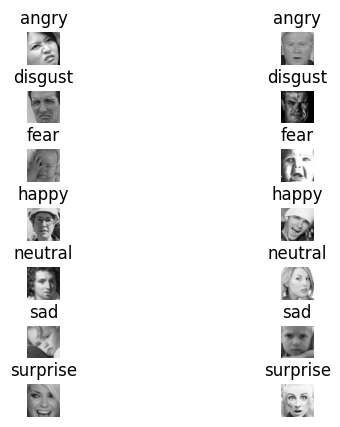

In [82]:
fig, ax = plt.subplots(7, 2, figsize=(6, 5))  # Adjust grid size

plt.subplots_adjust(hspace=0.8) 
idx = 0
for i in range(7):
    for j in range(2):
        image = images[idx]
        label = labels[idx]
        image = image / 255.0
        ax[i, j].imshow(image.squeeze(), cmap="gray")
        ax[i, j].set_title(label)
        ax[i, j].axis('off')  
        idx += 1

## Solution 3 - Adjust the loss function 

You can compute the class weights and then apply these during training to adjust the loss function. When the model makes a mistake on an underrepresented class, the loss will be multiplied by a larger weight. In this sense the model places more importance on getting the underrepresented class predictions correct than the overrepresented class, which can tackle the imbalance.

When we have computed the class weights, we can pass it to the model as another parameter e.g. 

```python
model.fit(
    train_dataset,
    epochs=10,
    class_weight=class_weight_dict  # or normalized_class_weight_dict
)
```

Below we experiment with using scikit learn's `compute_class_weight` and discover that we can perform our own calculation and achieve the same results. This will reduce complexity.

In [91]:
from sklearn.utils.class_weight import compute_class_weight

batch_size = 35

# By setting batch_size, we get a PrefetchDataset, not a usual tf.data.Dataset. 
# This data structure is optimized for batch processing. It is a lazy data pipeline that yields
# data when iterated over
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_folder,  # Path to the directory containing the subfolders for each class
    image_size=(48, 48),  # Resize all images to the desired size
    batch_size=batch_size,  # Batch size for training
    label_mode='categorical',  # Our folder names i.e. categories are strings
    shuffle=True  # Shuffle the data for randomness
)

# Get the labels from the dataset
all_labels = []
for _, labels in train_dataset:
    all_labels.append(labels.numpy())  # Convert Tensor to numpy

# Stack all label batches together
all_labels = np.concatenate(all_labels, axis=0)

# Convert one-hot encoded labels to integer labels
train_labels_int = np.argmax(all_labels, axis=1)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_int),  # Unique class indices
    y=train_labels_int  # Integer labels
)

# Convert to dictionary
class_weight_dict = dict(zip(np.unique(train_labels_int), class_weights))

print(class_weight_dict)

Found 26767 files belonging to 7 classes.
{0: 1.0301339285714286, 1: 10.279185867895546, 2: 1.0089332830757634, 3: 0.5494837107137726, 4: 0.8082555787058007, 5: 0.834721052795709, 6: 1.4583741963604664}


2025-01-21 12:14:55.520618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Comparing the scikit-learn class weights to manual calculations**

You can see we can calcultae the normalized weights manually rather than use scikit learn.

The model can deal with normalized weights.

In [119]:
normalized_weights = class_weights / np.sum(class_weights)
pd.DataFrame(index = np.unique(train_labels_int), data={"normalized_weights":normalized_weights})

,normalized_weights
0,0.064508
1,0.643693
2,0.063180
3,0.034409
4,0.050614
5,0.052271
6,0.091325


In [113]:
category_counts = df_meta_train["category"].value_counts().reset_index().sort_values(by="category").reset_index(drop=True)
category_counts["weights"] = np.sum(category_counts["count"])/ category_counts["count"]
category_counts["normalized_weights"] = category_counts["weights"]/ np.sum(category_counts["weights"])
category_counts

,category,count,weights,normalized_weights
0,angry,3712,7.210938,0.064508
1,disgust,372,71.954301,0.643693
2,fear,3790,7.062533,0.063180
3,happy,6959,3.846386,0.034409
4,neutral,4731,5.657789,0.050614
5,sad,4581,5.843047,0.052271
6,surprise,2622,10.208619,0.091325


In [120]:
category_counts["count"].values


array([3712,  372, 3790, 6959, 4731, 4581, 2622])

In [121]:
dict(zip(category_counts.index, category_counts["normalized_weights"]))

{0: 0.06450800153432945,
 1: 0.6436927464930938,
 2: 0.06318039622570737,
 3: 0.03440921133717932,
 4: 0.05061376066274168,
 5: 0.052271054725044945,
 6: 0.09132482902190346}

## Conclusion

Applying class weights to the loss function (solution 3) is the easiest to implement. There are warnings in the literature that if the class imbalance is extreme, it will not necessarily help. It is not clear whether our class imbalance falls into this category.

Approach: start with simplest solution to implement (i.e. solution 3) and then compare with solution 2 and a combination of both. 